# Continuation from the last part of 11.ipynb

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import lightgbm
from mypython import PurgedGroupTimeSeriesSplit as tss
import mypython.BactTest as bt
from sklearn import metrics

import time
import os
import matplotlib.pyplot as plt

## <p style="padding:10px;background-color:lightskyblue;margin:0;color:black;font-family:calibri;font-size:120%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Last Week 03.06-03.10</p>

In [ ]:
def model_strategy_return(x_path = '/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy', 
                          Y_path = '/home/qianshuofu/factor_qianshuofu/Data/data_label_oc_1.npy',
                          groups_path = '/home/qianshuofu/factor_qianshuofu/Data/data_index.npy',
                          parameters=[(0.1,0.1,0.003)]):
    days = int(Y_path[-5])
    close_open = (Y_path[-8] == 'o')

    x,Y = np.load(x_path),np.load(Y_path)
    y_return_oc, y_return_cc, y = Y[:,0], Y[:,1], Y[:,2]
    groups = np.load(groups_path,allow_pickle=True)

    cv = tss.PurgedGroupTimeSeriesSplit(n_splits=2)
    (train_index, test_index) = next(cv.split_2(x,y,groups[:,1],splits_minus=1))  # Just split one time to do research
    x_train, y_train, x_test, y_true, groups_train, groups_test = x[train_index], y[train_index], x[test_index], y[test_index], groups[:,1][train_index], groups[:,1][test_index]

    dataset = lightgbm.Dataset(x_train, y_train)
    model = lightgbm.train(params={}, train_set=dataset)
    y_pred = model.predict(x_test)

    tss.plot_ic(y,[test_index],[y_pred],groups[:,1],continuous=True)
    for (l,s,c) in parameters:
      u,daily_return = bt.strategy_return(Y[test_index],y_pred,groups[test_index],hold_days=days,ahead_steps=days,close_open=close_open,\
                                      long_ratio=l,short_ratio=s,cost_ratio=c)

In [ ]:
for Y_path in ['_cc_1','_oc_1','_oc_2','_oc_3']:
    print('Return_type:' + Y_path)
    model_strategy_return(Y_path='/home/qianshuofu/factor_qianshuofu/Data/data_label{}.npy'.format(Y_path),
                          parameters=[(0.01,0.01,0.003),(0.05,0.05,0.003),(0.1,0.1,0.003),(0.05,0.05,0.002)])

#### Parameters : ( long_ratio, short_ratio, cost_ratio )
#### Close_close return 1 day $\qquad\qquad\qquad\qquad\qquad\qquad $ Close_open return 1 day
|Parameters|mean|std|sharpe|maxdown|---------|Parameters|mean|std|sharpe|maxdown|
|----------|----|---|------|-------|---------|----------|----|---|------|-------|
|(0.01, 0.01, 0.003)|0.54%|1.06%|7.93|-1.70%||(0.01, 0.01, 0.003)|0.04%|0.80%|0.65|-5.32%|
|(0.05, 0.05, 0.003)|0.14%|0.42%|5.01|-1.62%||(0.05, 0.05, 0.003)|-0.02%|0.60%|-0.78|-7.37%|
|(0.10, 0.10, 0.003)|0.04%|0.32%|1.29|-2.41%||(0.10, 0.10, 0.003)|-0.07%|0.54%|-2.24|-13.96%|
|(0.05, 0.05, 0.002)|0.24%|0.42%|8.81|-0.92%||(0.05, 0.05, 0.002)|0.08%|0.60%|1.87|-4.01%|

#### Mean IC from 2022-02 ~ 2022-11:
#### close_close 1 day: 0.1162
#### close_open  1 day: 0.1025
#### close_open  2 day: 0.0840
#### close_open  3 day: 0.0761

In [ ]:
# The ic from 2022-02-18 ~ 2022-11-24 is 0.116 for close_close return and 0.10 for close_open return. Both are bad.
# close_close backtest performance is better than close_open for the factor discern the stock up to the increase limit. But it's not easy to buyin these kind of stocks in the next day.
# The backtest performance if we decrease the long_ratio and short_ratio.
# The backtest is sensitive to the cost_ratio.

In [ ]:
# Test the two groups feature model

In [ ]:
x_path = '/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy'
Y_path = '/home/qianshuofu/factor_qianshuofu/Data/data_label_oc_1.npy'
groups_path = '/home/qianshuofu/factor_qianshuofu/Data/data_index.npy'

x,Y = np.load(x_path),np.load(Y_path)
y_return_oc, y_return_cc, y = Y[:,0], Y[:,1], Y[:,2]
groups = np.load(groups_path,allow_pickle=True)

cv = tss.PurgedGroupTimeSeriesSplit(n_splits=2)
(train_index, test_index) = next(cv.split_2(x,y,groups[:,1],splits_minus=1)) 
x_train, y_train, x_test, y_true, groups_train, groups_test = x[train_index], y[train_index], x[test_index], y[test_index], groups[:,1][train_index], groups[:,1][test_index]

model_0 = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
feature_importance = model_0.feature_importance()
feature_index_1 = [i for i in range(len(feature_importance)) if feature_importance[i] > 0]
feature_index_2 = [i for i in range(len(feature_importance)) if feature_importance[i] == 0]

model_1 = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train[:,feature_index_1],y_train))
y_pred_1 = model_1.predict(x_test[:,feature_index_1])
y_resudial = y_true - y_pred_1

model_2 = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train[:,feature_index_2],y_train))
y_pred_2 = model_2.predict(x_test[:,feature_index_2])

y_pred = y_pred_1 + y_pred_2

tss.plot_ic(y,[test_index],[y_pred_1],groups[:,1],continuous=True)
tss.plot_ic(y,[test_index],[y_pred],groups[:,1],continuous=True)

## <p style="padding:10px;background-color:lightskyblue;margin:0;color:black;font-family:calibri;font-size:120%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Predict OO return and backtest with vwap, Compare to return OC</p>

In [ ]:
# one thing: backtest the return from tomorrow's open to tomorrow after tomorrow's open with cost ratio 0.0035
# use vwap price to calculate return in the backtest
# the other thing: split the features according to the time interval
# Split long strategy and short strategy

# Don't forget to correct the tss.plot function!

### Predict OO from next day to next next day

n_groups:964,n_splits:1
group_test_starts:range(771, 964, 193)
group_train_starts:range(0, 193, 193)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.212590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256275
[LightGBM] [Info] Number of data points in the train set: 725825, number of used features: 1005
[LightGBM] [Info] Start training from score -0.001792


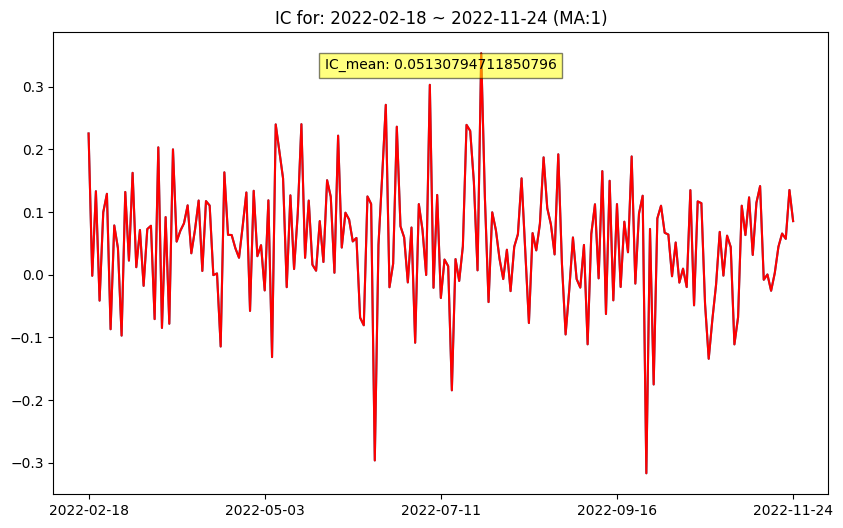

In [8]:
x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y2 = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_label_oo_1.npy')
groups = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_index.npy',allow_pickle=True)
group = groups[:,1]

train_index, test_index = next(tss.PurgedGroupTimeSeriesSplit(n_splits=2).split_2(x,y2,group,splits_minus=1))
x_train, x_test, y_train, y_test, group_train, group_test = x[train_index], x[test_index], y2[train_index], y2[test_index], group[train_index], group[test_index]

model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
y_pred = model.predict(x_test)

tss.plot_ic(y_test,y_pred,group_test,continuous=True)

n_groups:964,n_splits:5
group_test_starts:range(424, 964, 108)
group_train_starts:range(0, 540, 108)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.419684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256271
[LightGBM] [Info] Number of data points in the train set: 396280, number of used features: 1005
[LightGBM] [Info] Start training from score -0.002310
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.398592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256273
[LightGBM] [Info] Number of data points in the train set: 398523, number of used features: 1005
[LightGBM] [Info] Start training from score -0.002703
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.229327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256

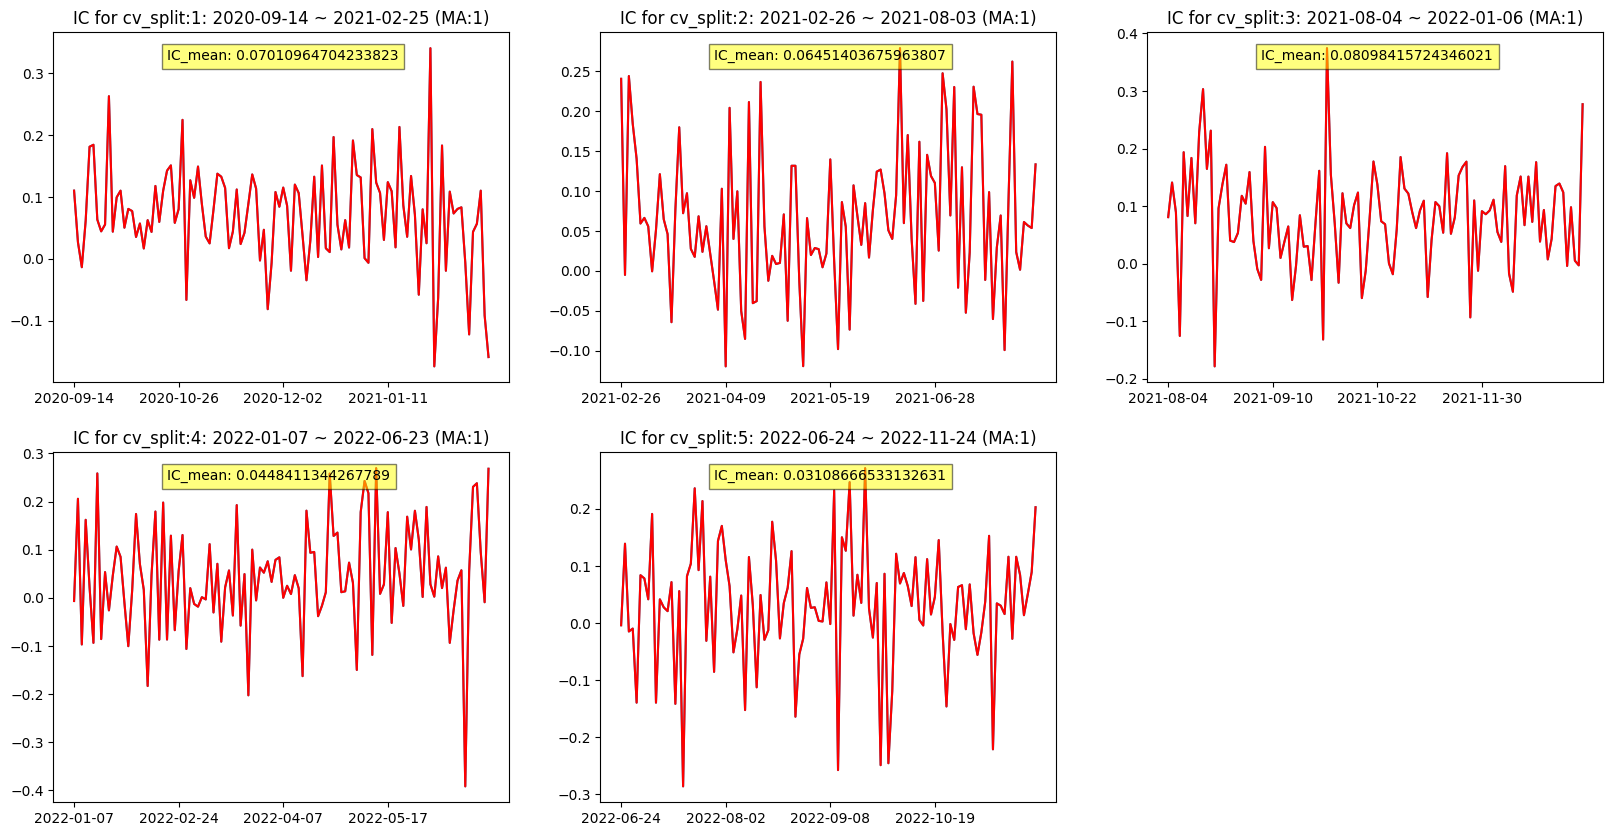

In [9]:
x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y2 = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_label_oo_1.npy')
groups = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_index.npy',allow_pickle=True)
group = groups[:,1]

cv = tss.PurgedGroupTimeSeriesSplit(n_splits=5)
y_test_list = []
y_pred_list2 = []
group_list = []
test_index_list = []
for i, (tr,te) in enumerate(cv.split_2(x,y2,group)):
    x_train, x_test, y_train, y_test, group_train, group_test = x[tr], x[te], y2[tr], y2[te], group[tr], group[te]
    model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
    y_pred = model.predict(x_test)

    y_test_list.append(y_test)
    y_pred_list2.append(y_pred)
    group_list.append(group_test)
    test_index_list.append(te)

tss.plot_ic(y_test_list,y_pred_list2,group_list,continuous=False)

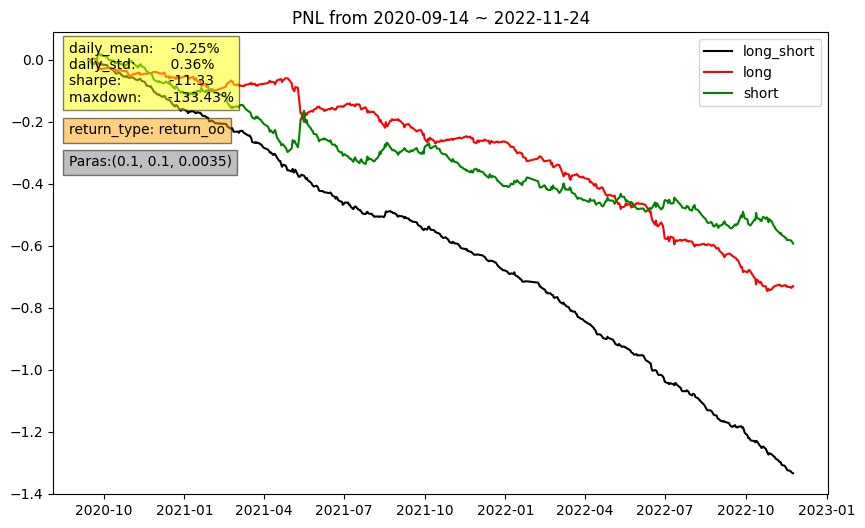

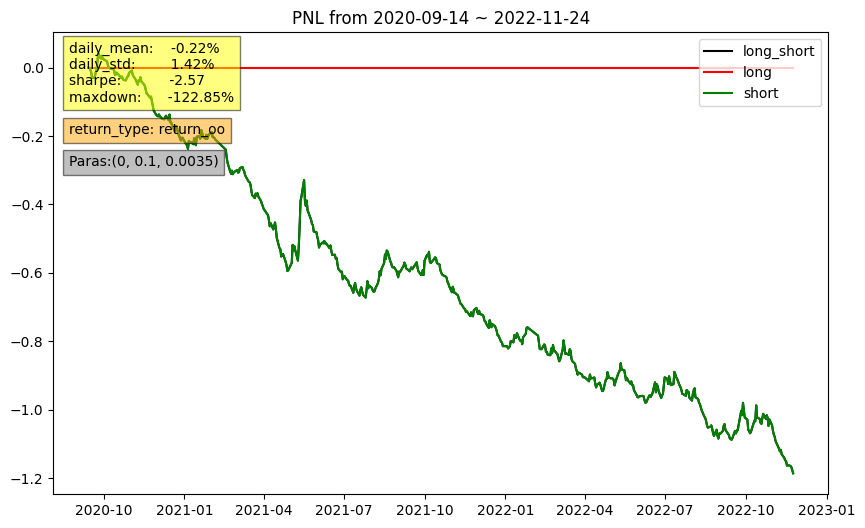

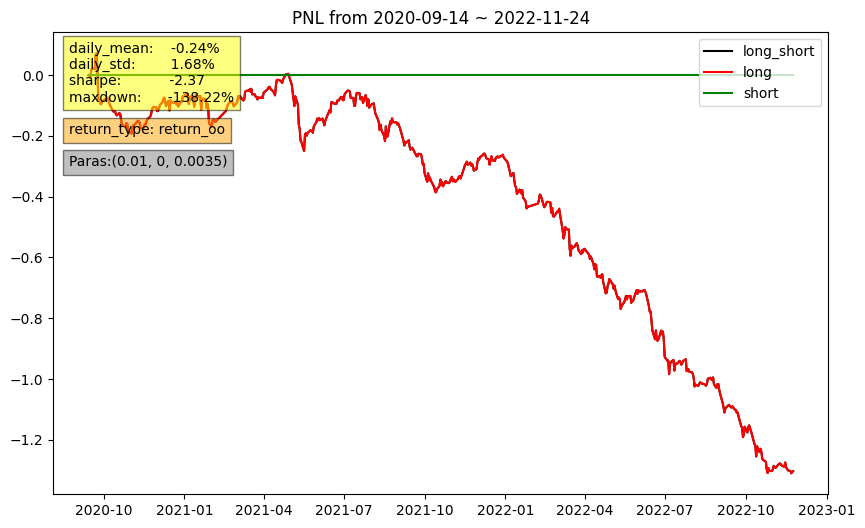

In [10]:
return_oc = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_return_oc_vwap.npy')
return_co = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_return_co_vwap.npy')
t_i = sum(test_index_list,[])
u,daily_rrturn = bt.backtest(np.concatenate(y_pred_list2),groups[t_i],return_oc[t_i],return_co[t_i],return_type='return_oo',long_ratio=0.1,short_ratio=0.1,cost_ratio=0.0035)
u,daily_rrturn = bt.backtest(np.concatenate(y_pred_list2),groups[t_i],return_oc[t_i],return_co[t_i],return_type='return_oo',long_ratio=0,short_ratio=0.1,cost_ratio=0.0035)
u,daily_rrturn = bt.backtest(np.concatenate(y_pred_list2),groups[t_i],return_oc[t_i],return_co[t_i],return_type='return_oo',long_ratio=0.01,short_ratio=0,cost_ratio=0.0035)

### Predict OC in next day

In [11]:
x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_label_oc_1.npy')
groups = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_index.npy',allow_pickle=True)
group = groups[:,1]

train_index, test_index = next(tss.PurgedGroupTimeSeriesSplit(n_splits=2).split_2(x,y,group,splits_minus=1))
x_train, x_test, y_train, y_test, group_train, group_test = x[train_index], x[test_index], y[train_index], y[test_index], group[train_index], group[test_index]

# model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
# y_pred = model.predict(x_test)

# tss.plot_ic(y_test,y_pred,group_test,continuous=True)

n_groups:964,n_splits:1
group_test_starts:range(771, 964, 193)
group_train_starts:range(0, 193, 193)


n_groups:964,n_splits:5
group_test_starts:range(424, 964, 108)
group_train_starts:range(0, 540, 108)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.408593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256271
[LightGBM] [Info] Number of data points in the train set: 396280, number of used features: 1005
[LightGBM] [Info] Start training from score -0.019460
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.366700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256273
[LightGBM] [Info] Number of data points in the train set: 398523, number of used features: 1005
[LightGBM] [Info] Start training from score -0.019498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.422691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256

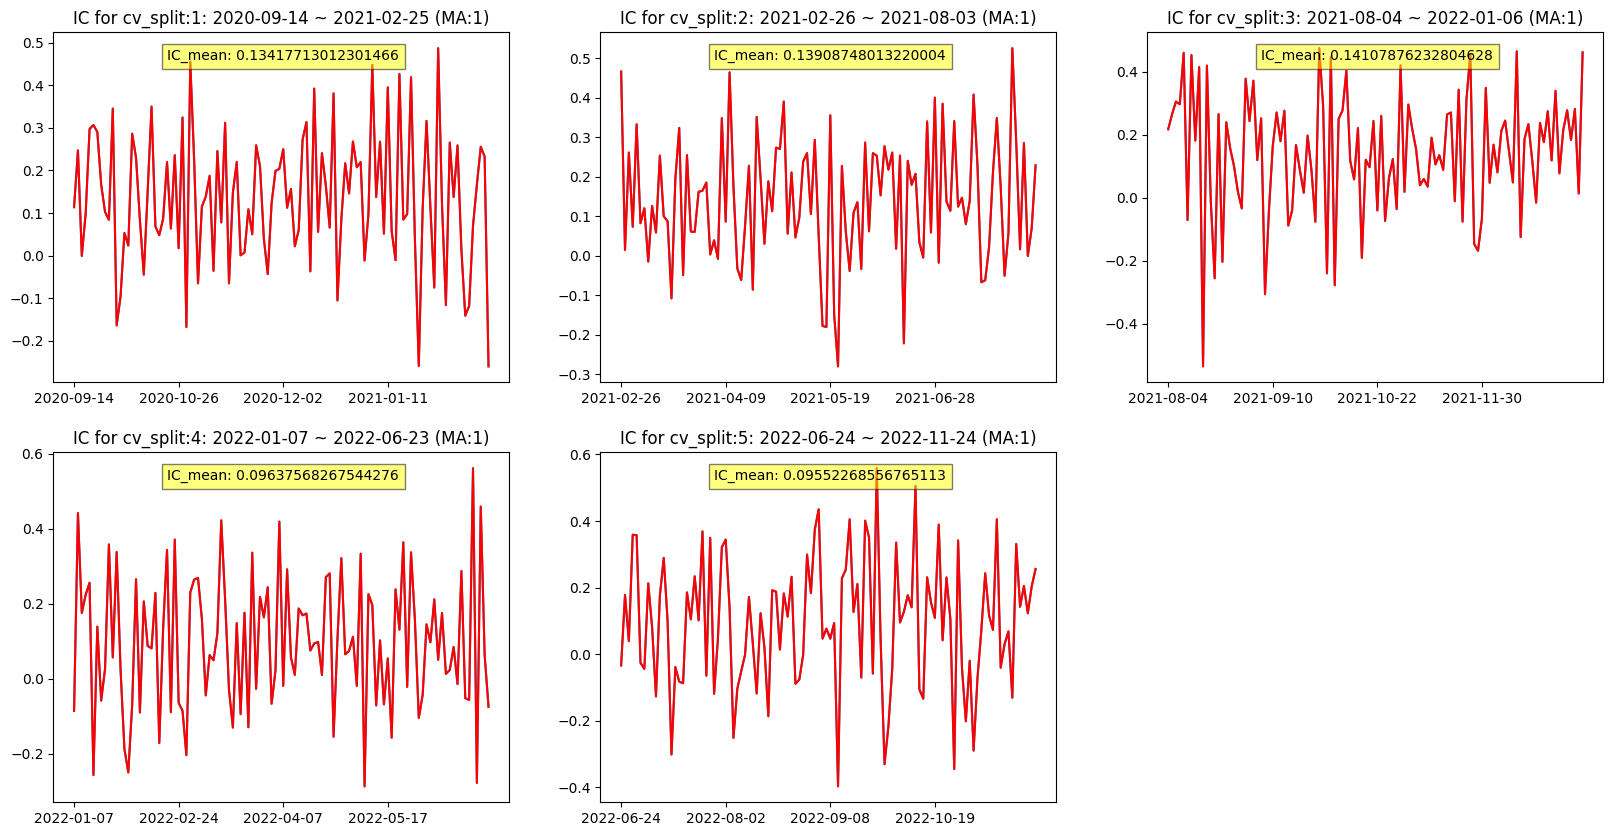

In [12]:
x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_label_oc_1.npy')
groups = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_index.npy',allow_pickle=True)
group = groups[:,1]

cv = tss.PurgedGroupTimeSeriesSplit(n_splits=5)
y_test_list = []
y_pred_list = []
group_list = []
test_index_list = []
for i, (tr,te) in enumerate(cv.split_2(x,y,group)):
    x_train, x_test, y_train, y_test, group_train, group_test = x[tr], x[te], y[tr], y[te], group[tr], group[te]
    model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
    y_pred = model.predict(x_test)

    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    group_list.append(group_test)
    test_index_list.append(te)

tss.plot_ic(y_test_list,y_pred_list,group_list,continuous=False)

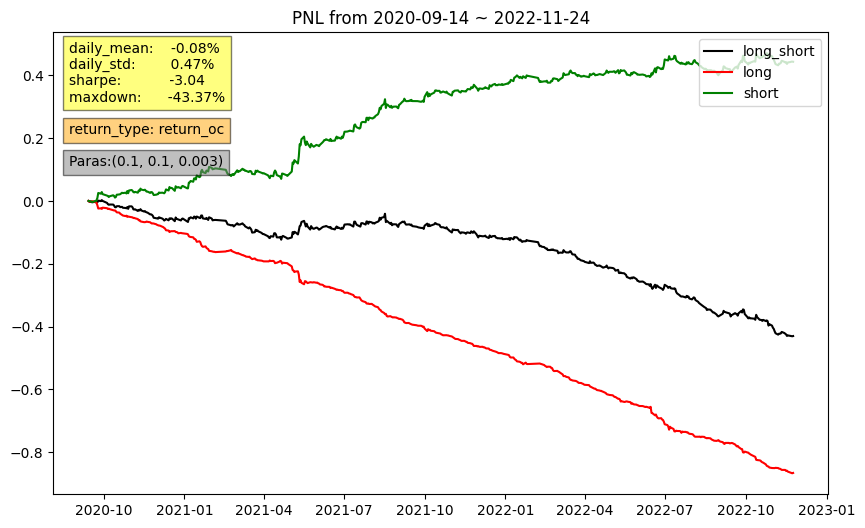

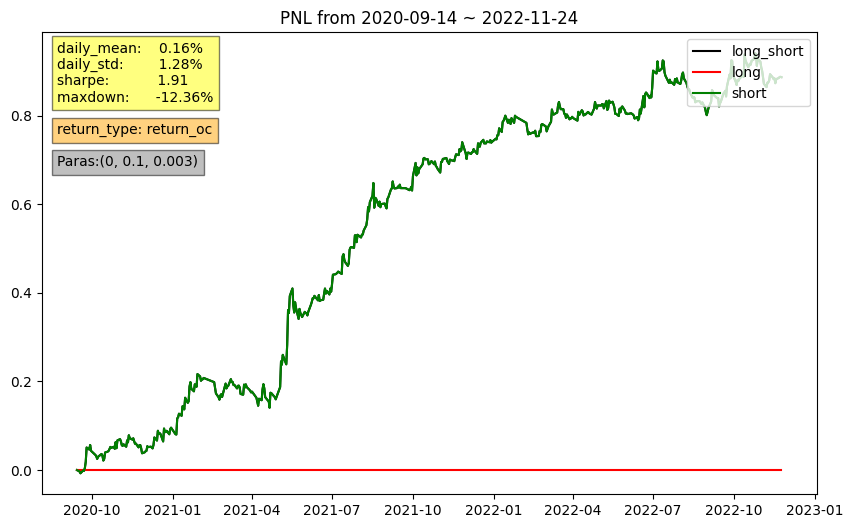

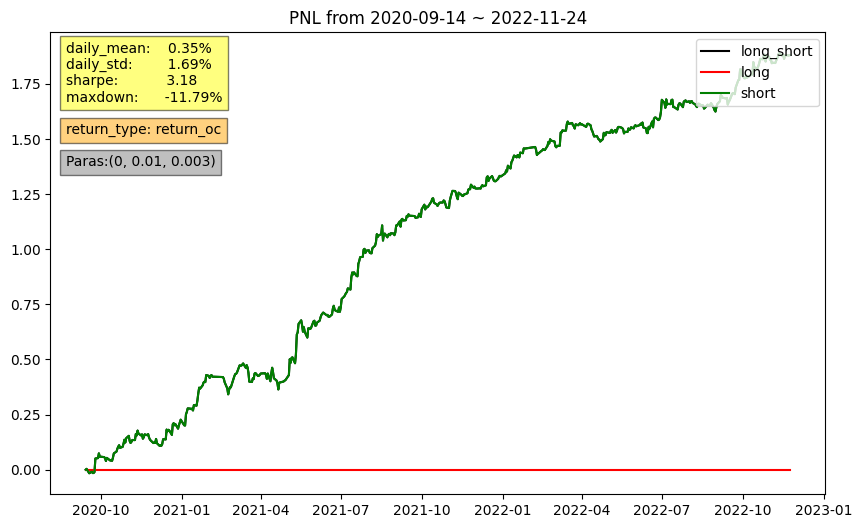

In [13]:
return_oc = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_return_oc_vwap.npy')
return_co = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_return_co_vwap.npy')
t_i = sum(test_index_list,[])
u,daily_rrturn = bt.backtest(np.concatenate(y_pred_list),groups[t_i],return_oc[t_i],return_co[t_i],return_type='return_oc',long_ratio=0.1,short_ratio=0.1,cost_ratio=0.003)
u,daily_rrturn = bt.backtest(np.concatenate(y_pred_list),groups[t_i],return_oc[t_i],return_co[t_i],return_type='return_oc',long_ratio=0,short_ratio=0.1,cost_ratio=0.003)
u,daily_rrturn = bt.backtest(np.concatenate(y_pred_list),groups[t_i],return_oc[t_i],return_co[t_i],return_type='return_oc',long_ratio=0,short_ratio=0.01,cost_ratio=0.003)

## <p style="padding:10px;background-color:lightskyblue;margin:0;color:black;font-family:calibri;font-size:120%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">About long and short</p>

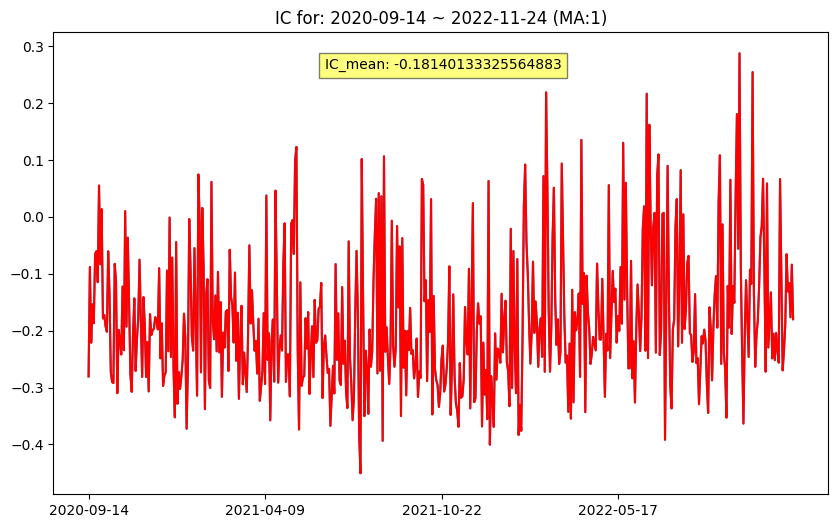

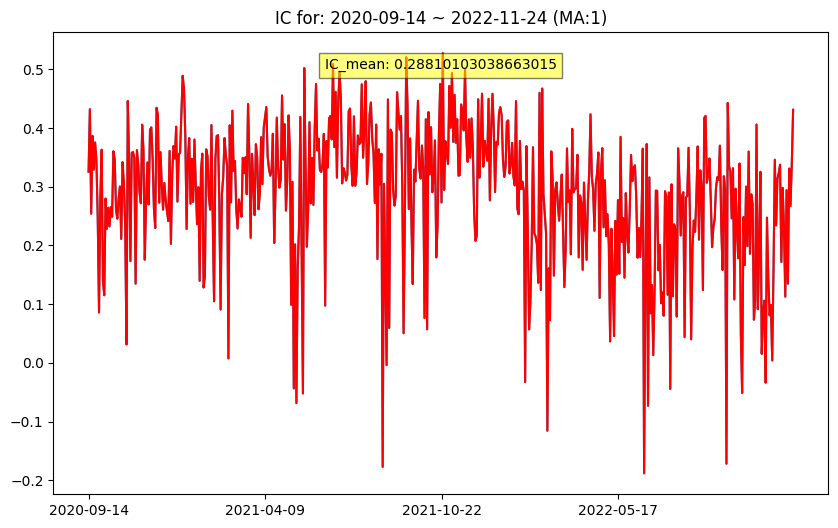

In [14]:
# split according to y_true
df = pd.DataFrame({'yy':y[t_i],'pred':np.concatenate(y_pred_list),'group':group[t_i]})
df.yy = df.groupby(['group'])['yy'].rank(pct=True)
df.pred = df.groupby(['group'])['pred'].rank(pct=True)
df1 = df[df.yy >= 0.5]
df2 = df[df.yy < 0.5]

tss.plot_ic(np.array(df1.yy),np.array(df1.pred),np.array(df1.group),continuous=True)
tss.plot_ic(np.array(df2.yy),np.array(df2.pred),np.array(df2.group),continuous=True)

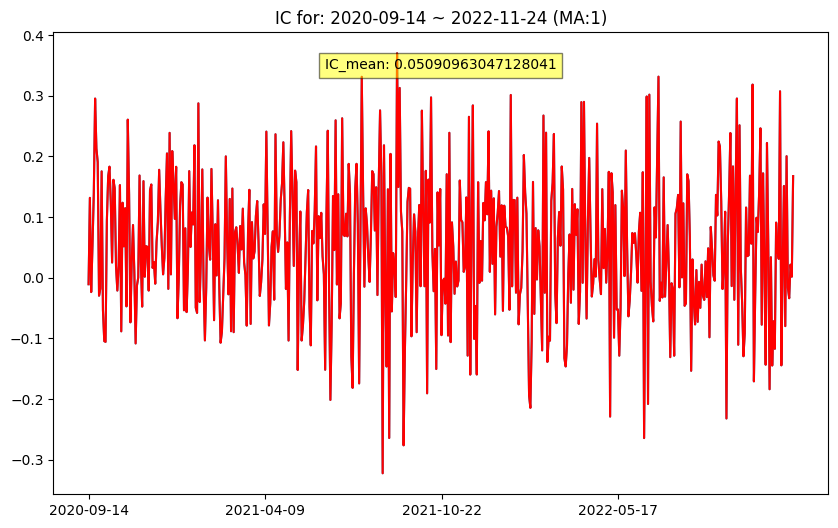

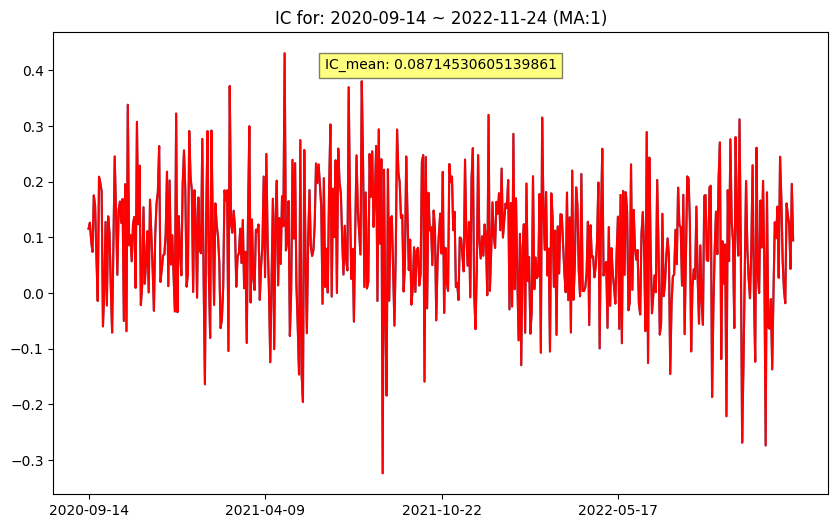

In [15]:
# split according to y_pred
df = pd.DataFrame({'yy':y[t_i],'pred':np.concatenate(y_pred_list),'group':group[t_i]})
df.yy = df.groupby(['group'])['yy'].rank(pct=True)
df.pred = df.groupby(['group'])['pred'].rank(pct=True)
df1 = df[df.pred >= 0.5]
df2 = df[df.pred < 0.5]

tss.plot_ic(np.array(df1.yy),np.array(df1.pred),np.array(df1.group),continuous=True)
tss.plot_ic(np.array(df2.yy),np.array(df2.pred),np.array(df2.group),continuous=True)

[Text(0.5, 0, 'y_pred'),
 Text(0, 0.5, 'y_true'),
 Text(0.5, 1.0, 'The mean y_true with y_pred group')]

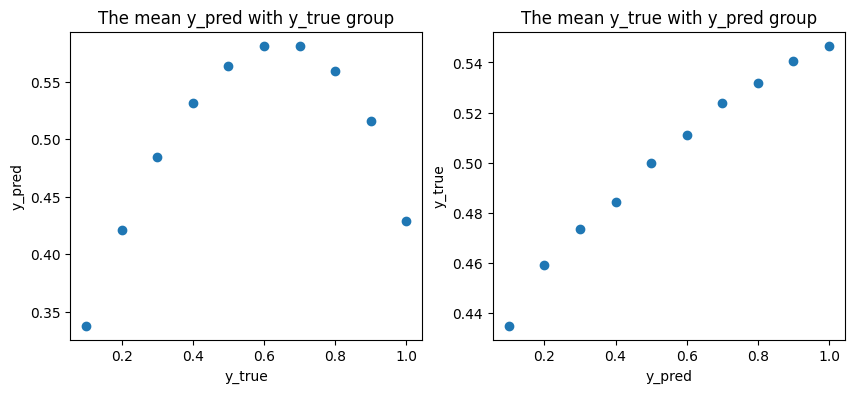

In [16]:
# split according to y_true is more sensiable. 
# The intuitive feeling of the prediction result:
# The True y is:        1,2,3,4,5,  6,7,8,9,10
# The Pred y is:        1,2,4,8,7,  10,9,6,5,3

df = pd.DataFrame({'yy':y[t_i],'pred':np.concatenate(y_pred_list    ),'group':group[t_i]})
df.yy = df.groupby(['group'])['yy'].rank(pct=True)
df.pred = df.groupby(['group'])['pred'].rank(pct=True)
pred_list = []
yy_list = []
for i in range(1,11):
    list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    pred_list.append(df[df.yy<=list[i]][df.yy>list[i-1]].pred.mean())
    yy_list.append(df[df.pred<=list[i]][df.pred>list[i-1]].yy.mean())

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.scatter(list[1:],pred_list)
# ax1.plot(list[1:],list[1:])
ax1.set(xlabel='y_true',ylabel='y_pred',title='The mean y_pred with y_true group')
ax2.scatter(list[1:],yy_list)
# ax2.plot(list[1:],list[1:])
ax2.set(xlabel='y_pred',ylabel='y_true',title='The mean y_true with y_pred group')

## <p style="padding:10px;background-color:lightskyblue;margin:0;color:black;font-family:calibri;font-size:120%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">Group feature according to the time interval</p>

n_groups:964,n_splits:5
group_test_starts:range(424, 964, 108)
group_train_starts:range(0, 540, 108)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28560
[LightGBM] [Info] Number of data points in the train set: 396280, number of used features: 112
[LightGBM] [Info] Start training from score -0.019460
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28560
[LightGBM] [Info] Number of data points in the train set: 398523, number of used features: 112
[LightGBM] [Info] Start training from score -0.019498
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28560
[

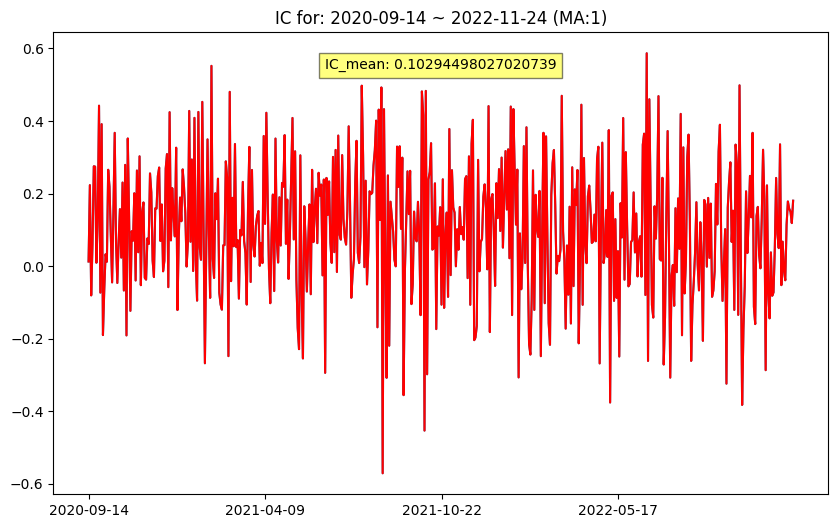

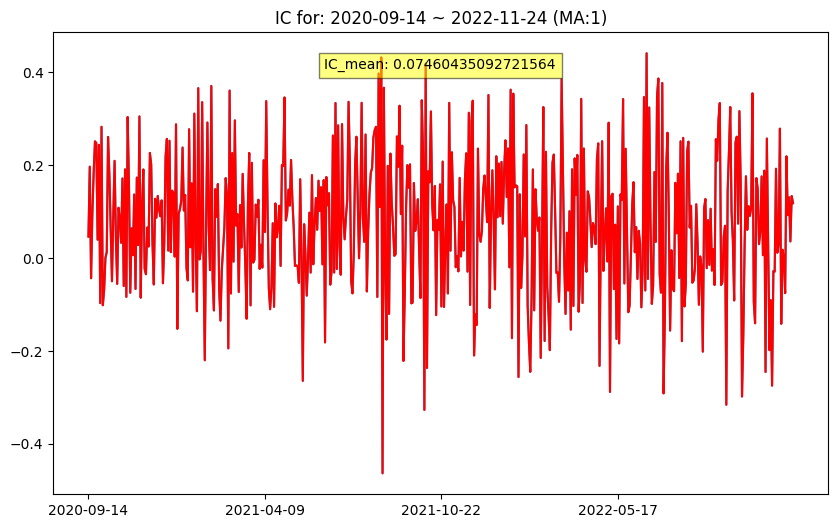

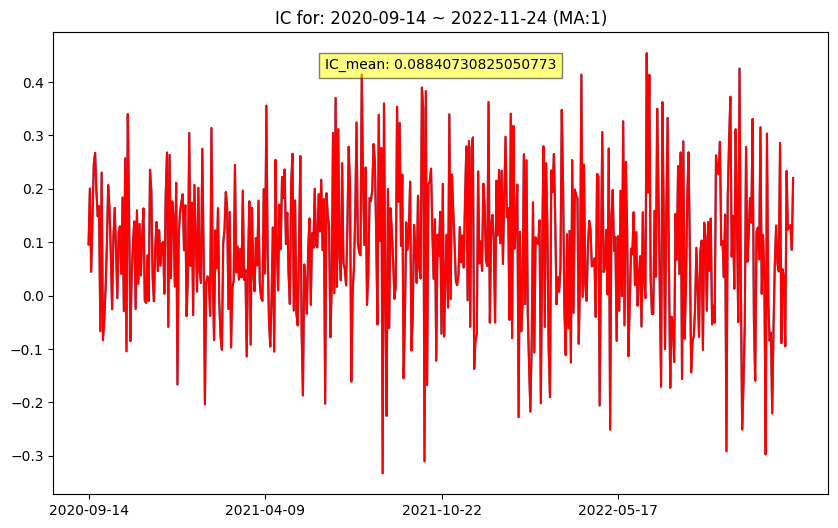

In [17]:
# Group feature according to the time interval
x_first = x[:,range(0,len(x[0]),9)]
x_mid = x[:,range(4,len(x[0]),9)]
x_last = x[:,range(8,len(x[0]),9)]

for x in [x_first,x_mid,x_last]:
    # train_index, test_index = next(tss.PurgedGroupTimeSeriesSplit(n_splits=2).split_2(x,y,group,splits_minus=1))
    # x_train, x_test, y_train, y_test, group_train, group_test = x[train_index], x[test_index], y[train_index], y[test_index], group[train_index], group[test_index]

    # model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
    # y_pred = model.predict(x_test)

    # tss.plot_ic(y_test,y_pred,group_test,continuous=True)

    cv = tss.PurgedGroupTimeSeriesSplit(n_splits=5)
    y_test_list = []
    y_pred_list_group = []
    group_list = []
    test_index_list = []
    for i, (tr,te) in enumerate(cv.split_2(x,y,group)):
        x_train, x_test, y_train, y_test, group_train, group_test = x[tr], x[te], y[tr], y[te], group[tr], group[te]
        model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
        y_pred = model.predict(x_test)

        y_test_list.append(y_test)
        y_pred_list_group.append(y_pred)
        group_list.append(group_test)
        test_index_list.append(te)

    tss.plot_ic(np.concatenate(y_test_list),np.concatenate(y_pred_list_group),np.concatenate(group_list),continuous=True)

## <p style="padding:10px;background-color:lightskyblue;margin:0;color:black;font-family:calibri;font-size:120%;text-align:center;border-radius: 25px 25px;overflow:hidden;font-weight:500">OpenFE and features</p>

n_groups:964,n_splits:1
group_test_starts:range(771, 964, 193)
group_train_starts:range(0, 193, 193)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 7.212120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512550
[LightGBM] [Info] Number of data points in the train set: 725825, number of used features: 2010
[LightGBM] [Info] Start training from score -0.020333
0 0 1
6 0 1
88 0 1
103 0 1
105 0 1
115 0 1
142 1 2
162 0 1
166 0 1
173 0 1
200 0 1
203 0 2
230 0 3
242 0 1
254 1 2
283 0 1
331 0 1
358 0 1
368 0 1
370 0 1
376 0 1
425 1 2
490 0 1
491 0 1
558 0 1
560 0 1
565 0 2
572 0 1
590 0 1
733 0 1
753 0 1
790 0 1
806 0 1
809 0 1
825 0 1
826 0 1
842 0 1
843 0 1
851 1 2
861 0 1
863 0 1
869 0 1
928 0 1
934 0 1
1002 1 2
1057 0 1
1094 0 1
1117 0 1
1167 0 1
1168 0 1
1182 0 1
1191 0 1
1212 0 1


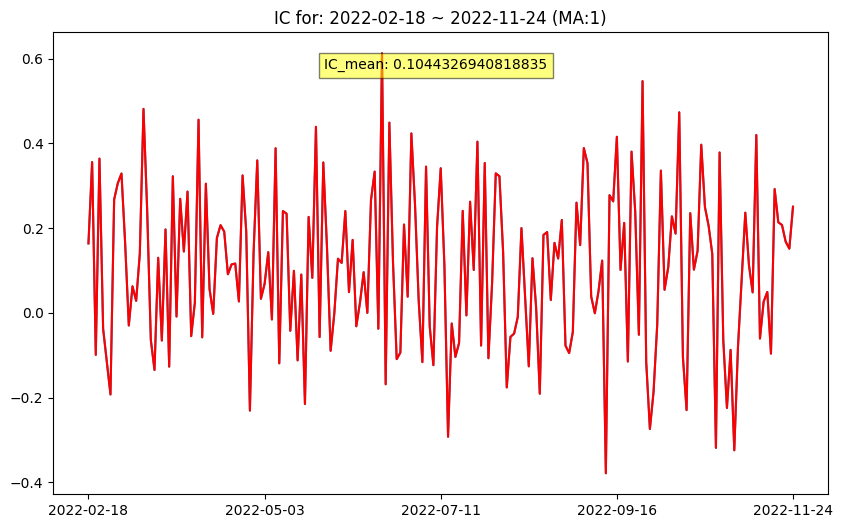

In [18]:
# Test whether there are features that are worse than random features.
# It is not a serious problem in this model

x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_label_oc_1.npy')
groups = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_index.npy',allow_pickle=True)
group = groups[:,1]

x_random = np.concatenate([np.random.permutation(x[:,i])[:,np.newaxis] for i in range(len(x[0]))],axis=1)
x_random = np.concatenate([x,x_random],axis=1)


train_index, test_index = next(tss.PurgedGroupTimeSeriesSplit(n_splits=2).split_2(x_random,y,group,splits_minus=1))
x_train, x_test, y_train, y_test, group_train, group_test = x_random[train_index], x_random[test_index], y[train_index], y[test_index], group[train_index], group[test_index]

model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
y_pred = model.predict(x_test)
feature_importance = model.feature_importance()

tss.plot_ic(y_test,y_pred,group_test,continuous=True)

for i in range(int(len(feature_importance)/2)):
    if feature_importance[i] < feature_importance[i+1242]:
        print(i,feature_importance[i],feature_importance[i+1242])

In [7]:
# pip install openfe
# spend too much time to get the result

from openfe import openfe, transform
ofe = openfe()
df_columns = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_column.npy',allow_pickle=True)
df_columns = [str(i).replace(':','') for i in df_columns]
features = ofe.fit(data=pd.DataFrame(x_train,columns=df_columns), label=pd.DataFrame(y_train,columns=['return_oc']),n_jobs=100)
x_train_ofe, x_test_ofe = transform(pd.DataFrame(x_train,columns=df_columns), pd.DataFrame(x_test,columns=df_columns),n_jobs=100)

The number of candidate features is 6510705
Start stage I selection.


  0%|          | 1/400 [21:16<141:28:33, 1276.48s/it]


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.